# Taylor Swift the EDA's Tour
## Problem Statement

 - Given Taylor Swift's wide range of songs and their lyrics, can we effectively classify the songs based solely on information derived from the lyrics?
- Hypothesis: I expect to see the sugary-sweet pop songs to cluster closeley to one another, while the moody and dark songs find a separate cluster.

## Data Collection
All raw data is credited to the below:
- ISHIKA JOHARI
- Taylor Swift All Lyrics (64 Albums) [with TTPD]
- https://www.kaggle.com/datasets/ishikajohari/taylor-swift-all-lyrics-30-albums

Data format: multiple .txt files organized by Album. Johari also provided multiple lookup files with Song and Album names/IDs preassigned. I decided to not use these helper files to more accurately portray a business scenario.

## Data Cleaning
See each cell for more details.

Imports

In [1]:
# Standard library imports
import os
import re
# Third-party library imports
import ftfy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from textblob import TextBlob

### Load Data
Drill through to each file (song) in the folder Albums. Derive the Album name, Song name, and Lyrics (file value) from each file and add them to a dataframe. 
#### Further notes
After discussing the lyrics with a subject matter expert (my wife). We excluded a number of albums from our dataset. Typically, the albums removed were extraneous. For example, the 1989 Taylor's Version Webstore Deluxe and the 1989 Taylor's VersionTangerine Edition have the same 23 songs listed. The albums we kept are listed below:

- 1989
- 1989 Taylor's Version Deluxe
- Carolina from the motion picture Where the Crawdads Sing
- Evermore
- Fearless
- Fearless Taylor's Version
- Folklore
- Lover
- Midnights
- Red
- Red Taylor's Version
- Reputation
- Speak Now
- Speak Now Taylor's Version Digital Deluxe
- TaylorSwift
- The Tortured Poets Department - The Anthology


In [2]:
data_dictionary = 'data/data/Albums'
data = []
for root, dirs, files in os.walk(data_dictionary):
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    lyrics = f.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='latin-1') as f:
                    lyrics = f.read()
            album_name = os.path.basename(root.split(os.path.sep)[-1]) 
            song_name = os.path.splitext(file)[0]
            data.append({'Album': album_name, 'Song': song_name, 'Lyrics': lyrics})
df = pd.DataFrame(data)

apply FTFY fix_text on the Lyrics and Song columns. This probably isn't necessary because the song titles are derived directly from the path, and we handle a little encoding in the above cell. It's a good practice though in case it does help out.

In [3]:
df['Lyrics'] = df['Lyrics'].apply(lambda x: ftfy.fix_text(x) if pd.notnull(x) else x)
df['Song'] = df['Song'].apply(lambda x: ftfy.fix_text(x) if pd.notnull(x) else x)

Our lyrics come through dirty. The first line on each txt file details the number of contributers to each set of lyrics. We want to remove these values. Additionally, the end of each lyric file has a numerical value followed by the word Embed. These need to be removed as well. 

In [4]:
def extract_lyrics(text):
    # Find the index of "Lyrics" in the text
    index = text.find("Lyrics")
    if index != -1:
        # Slice text from "Lyrics" onwards
        text = text[index + len("Lyrics"):].strip()
        # Apply numerical value and "Embed" removal only to the sliced text
        text = re.sub(r'(?<!\[)\b\d+\b(?!])', '', text)  # Remove numerical value
        text = re.sub(r'Embed\b', '', text)  # Remove the word "Embed"
    return text

I retain the original dirty lyrics and create a new column holding the trimmed lyrics.

In [5]:
df['Trimmed_Lyrics'] = df['Lyrics'].apply(extract_lyrics)

Eventually, I'm going to run sentiment analysis on each section of the songs. Since few songs have only one verse, I replace that string with Verse 1 so that it's analyzed within the same column as the other songs and not excluded later when removing extra columns.

In [6]:
for idx, row in df.iterrows():
    df.at[idx, 'Trimmed_Lyrics'] = row['Trimmed_Lyrics'].replace("[Verse]", "[Verse 1]").replace("[Verse :", "[Verse 1 :")

Within each song's lyrics, there are sections for lack of a better word (Verse 1, Bridge, Chorus, etc.). I extract a list of sections within each song and add that to the column Sections

In [7]:
def extract_sections(trimmed_lyrics):
    sections = re.findall(r'\[(.*?)\]', trimmed_lyrics)  # Extract sections within []
    cleaned_sections = []
    for section in sections:
        cleaned_section = section.split(':')[0].strip()  # Extract text before ':', if ':' exists. This catches rare instances of detailing who sings the song. IE [Verse 1: Taylor Swift]
        cleaned_sections.append(cleaned_section)
    return cleaned_sections  # Return the list of cleaned sections directly

In [8]:
df['Sections'] = df['Trimmed_Lyrics'].apply(extract_sections)

Create a list of unique sections. Each section will be it's own column eventually.

In [9]:
flattened_sections = [section for sublist in df['Sections'] for section in sublist]
unique_sections = list(set(flattened_sections))
#unique_sections

Count the number of sections (counting duplicates) for each song and assign that value to the new column Num_Sections

In [10]:
df['Num_Sections'] = df['Sections'].apply(len)

This replaces the extra information for some sections. Earlier, we bypass them when determining the section names, but now we completely remove the extra substring. For example: [Verse 1: Kendrick Lamar] becomes [Verse 1]

In [11]:
def preprocess_lyrics(lyrics):
    return re.sub(r':[^\]]+\]', ']', lyrics)

In [12]:
df['Trimmed_Lyrics'] = df['Trimmed_Lyrics'].apply(preprocess_lyrics)

We now extract the actual lyrics between each section and use those lyrics for the appropriate section-column's value

In [13]:
def clean_lyrics(trimmed_lyrics, section):
    pattern = rf'\[{re.escape(section)}[^[\]]*\]([^[\]]*)'  # Regex pattern to extract lyrics for the section
    match = re.search(pattern, trimmed_lyrics)
    if match:
        return match.group(1).strip()
    else:
        return '' 

In [14]:
for section in unique_sections:
    df[section] = df['Trimmed_Lyrics'].apply(lambda x: clean_lyrics(x, section))

Time for some hard values. For each album, assign an abbreviation so they can be viewed easier. Additionally, add the release_date for each album as a column. 

In [15]:
album_abv = {
 'Red_TaylorsVersion_': 'RED_TV',
 '.ipynb_checkpoints': 'NA',
 'SpeakNow_TaylorsVersion__DigitalDeluxe_': 'SpeakNow_TV',
 'THETORTUREDPOETSDEPARTMENT_THEANTHOLOGY': 'TTPD_Full',
 'Reputation': 'Rep.',
 'SpeakNow': 'SpeakNow',
 'Midnights': 'Midnights',
 'Fearless_TaylorsVersion_': 'Fearless_TV',
 'Lover': 'Lover',
 'Red': 'RED',
 'Fearless': 'Fearless',
 '1989_TaylorsVersion__Deluxe_': '1989_TV',
 'Carolina_FromTheMotionPictureWhereTheCrawdadsSing_': 'Carolina',
 'Evermore': 'Evermore',
 'Folklore': 'Folklore',
 'TaylorSwift': 'Debut',
 '1989': '1989'
}
release_date = { 
'Red_TaylorsVersion_': '11-12-2021',
'SpeakNow_TaylorsVersion__DigitalDeluxe_':'7-7-2023',
'THETORTUREDPOETSDEPARTMENT_THEANTHOLOGY' : '4-19-2024',
'Reputation':'10-10-2017',
'SpeakNow':'10-25-2010',
'Midnights': '10-21-2022',
'Fearless_TaylorsVersion_':'4-9-2021',
'Lover':'8-23-2019',
'Red': '11-12-2021',
'Fearless':'11-11-2008',
'1989_TaylorsVersion__Deluxe_': '10-27-2023',
'Carolina_FromTheMotionPictureWhereTheCrawdadsSing_':'6-24-2022',
'Evermore':'12-11-2020',
'Folklore':'7-24-2020',
'TaylorSwift': '3-18-2008',
'1989':'10-27-2014'}

map the release date and album abbreviations to each row appropriately

In [16]:
df['Release_Date'] = df['Album'].map(release_date) 
df['Album_ABV'] = df['Album'].map(album_abv)

### Sentiment Analysis
Using TextBlob, we now are able to get the data we truly want to analyze. I chose TextBlob for it's simplicity, and I was already familiar with it's ins and outs. 

#### Downsides
- TextBlob is a pretty simplistic NLP library. Specifically the sentiment analysis portion. As all words are weighted the same and being based on a lexicon, the nuances are not caught. Since lyrics are heavily nuanced strings of text, the sentiment score should be taken with a grain of salt. To more accurately decipher the sentiment, a more robust technique may be needed.

Let's begin!

This is the first step. We want to get the sentiment for the full set of lyrics in each row by applying the sentiment analysis to Trimmed_Lyrics


In [17]:
df['Sentiment_Score'] = df['Trimmed_Lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)

remove duplicate words so all words are weighted the same (the technically already are weighted the same, that's why the repetition provides such negative results). Since lyrics are different from other traditional textual values, I decided to remove all duplicate words. For example, in Shake it off, Taylor sings "Haters gonna hate hate hate". Since "hate" has such a low sentiment score, the repetition of this word makes the sentiment score value skew far negative. I thought it'd be nice to see what the sentiment score would be if no repetition is taken into context.

In [18]:
def remove_duplicates(text):
    return ' '.join(dict.fromkeys(text.split()))

In [19]:
df['Trimmed_Lyrics_No_Duplicates'] = df['Trimmed_Lyrics'].apply(remove_duplicates)

run sentiment score on this new column as well using TextBlob

In [20]:
df['No_Dup_Sent_Score'] = df['Trimmed_Lyrics_No_Duplicates'].apply(lambda x: TextBlob(x).sentiment.polarity)

Determine the average sentiment score with all words weighed the same and plot it compared to the average sentiment score when removing duplicates

In [21]:
avg_scores_abv = df.groupby('Album_ABV')[['Sentiment_Score', 'No_Dup_Sent_Score']].mean().reset_index()
melted_df = avg_scores_abv.melt(id_vars='Album_ABV', var_name='Score_Type', value_name='Average_Score')

### Average Sentiment Score per Album
#### Notable Findings
- Debut scores as the most positive album
- Speak Now Taylor's Version is the only album that became **more** negative compared to the original release
- Folklore and 1989 are the most negative albums as a whole
- By removing the duplicate words, the sentiment scores are shifted either more positive or more negative, but all remain within a reasonable distance from the Trimmed_Lyrics value

C:\Users\Owner\AppData\Local\Temp\ipykernel_18340\617101129.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


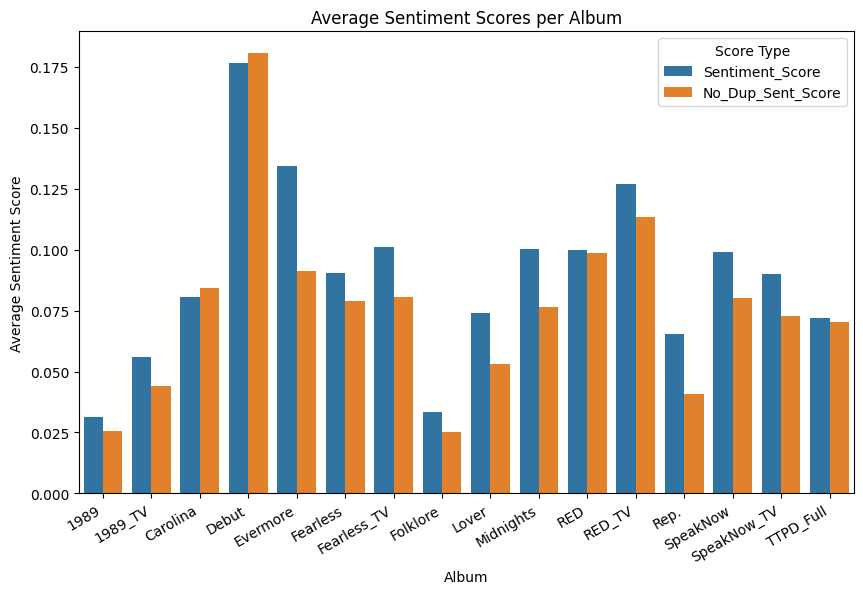

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Album_ABV', y='Average_Score', hue='Score_Type', data=melted_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.title('Average Sentiment Scores per Album')
plt.xlabel('Album')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Score Type')
plt.show()

I want to track the order in which each section first appears throughout the lyrics. To complete this, I first need a list of unique sections per song

In [23]:
def remove_duplicates_preserve_order(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

Since we are removing duplicate sections anyway, we might as well count them to see if anything interesting is found

In [24]:
df['No_Dup_Sections'] = df['Sections'].apply(remove_duplicates_preserve_order)
df['Num_No_Dup_Sections'] = df['No_Dup_Sections'].apply(len)

Plot the average number of sections and number of non-duplicate sections per album

C:\Users\Owner\AppData\Local\Temp\ipykernel_18340\3490773019.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


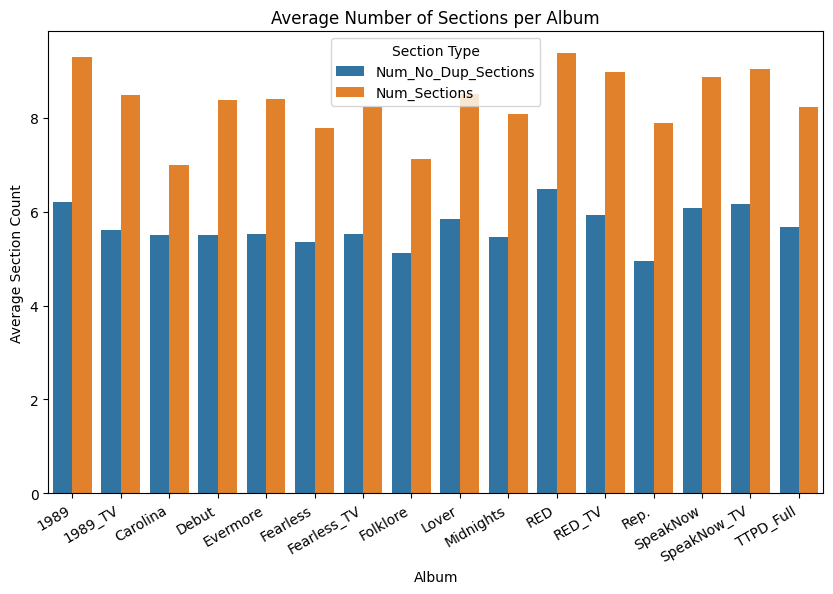

In [25]:
avg_sections = df.groupby('Album_ABV')[['Num_No_Dup_Sections', 'Num_Sections']].mean().reset_index()
melted_avg_sections = avg_sections.melt(id_vars='Album_ABV', var_name='Section_Type', value_name='Average_Section_Count')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Album_ABV', y='Average_Section_Count', hue='Section_Type', data=melted_avg_sections)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
# Customize the plot
plt.title('Average Number of Sections per Album')
plt.xlabel('Album')
plt.ylabel('Average Section Count')
plt.legend(title='Section Type')
plt.show()

Create new column that holds the order in which the section is present in the lyrics

In [26]:
for section in unique_sections:
    df[section + '_Order'] = df['No_Dup_Sections'].apply(lambda x: x.index(section) + 1 if section in x else None)

Calculate sentiment alalysis on each section and make new columns holding that information. Rather than output np.nan, if the text is null, I output a value beyond the boundary of the sentiment score. Later, I run some clustering analysis on this data, and I'd have to replace the np.nan values there with either a value outside of the range or a 0 (indicating true neutrality). 

In [27]:
def calculate_sentiment(text):
    if pd.isnull(text) or text == "":
        return -10
    else:
        blob = TextBlob(text)
        return blob.sentiment.polarity

In [28]:
sentiment_df = pd.DataFrame()
for section in unique_sections:
    sentiment_df[section + '_Sent'] = df[section].apply(calculate_sentiment)
df = pd.concat([df, sentiment_df], axis=1)

Calculate the percentage of null or empty strings for each column. I also count the number of -10 values there are since they represent missing values

In [29]:
def null_percentage(col):
    null_count = col.isnull().sum() + (col == '').sum() + (col == -10).sum()
    return (null_count/ len(col)) * 100

create a copy of the current dataframe because we're going to be dropping some columns and I don't want to have to backtrack to the beginning if I need to retry this

In [30]:
df_cleaned = df

#### Notable Findings
- Many columns hold a high percentage of null values. This is expected since some songs have a section called Guitar Solo or Instrumental Break. These columns wouldn't receive any lyrics, so the sentiment score column associated will have the same percentage of missing values. Additionally, a few records have infrequently used sections (such as Verse 6 or Verse 5) so these output a high percentage of missing values as well.

In [31]:
null_percentage_df = df.apply(null_percentage)
null_percentage_df = null_percentage_df.reset_index()
null_percentage_df.columns = ['Column', 'Percentage of null values']
for index, row in null_percentage_df.iterrows():
    if row['Percentage of null values'] > 0:
        print(f"{row['Column']}: {row['Percentage of null values']}%")
float_cols = df_cleaned.select_dtypes(include=['float64']).columns

for col in float_cols:
    df_cleaned[col] = df_cleaned[col].fillna(-10)
non_float_cols = df_cleaned.select_dtypes(exclude=['float64']).columns
for col in non_float_cols:
    df_cleaned[col] = df_cleaned[col].fillna('None').replace('', 'None')

Pre-Chorus 1: 99.32432432432432%
Chorus: 2.364864864864865%
Verse 6: 99.66216216216216%
Breakdown: 92.56756756756756%
Refrain: 97.97297297297297%
Pre-Chorus: 49.32432432432432%
Chorus 1: 99.32432432432432%
Verse 2: 11.486486486486488%
Video directed by Mark Romanek: 99.66216216216216%
Recorder click: 99.66216216216216%
Spoken Outro: 99.66216216216216%
Verse 3: 84.45945945945947%
Verse 5: 99.66216216216216%
Verse 4: 98.98648648648648%
Chorus 2: 99.32432432432432%
Post-Chorus: 74.66216216216216%
Bridge: 8.783783783783784%
Instrumental bridge: 100.0%
Intro: 85.13513513513513%
Interlude: 98.64864864864865%
Outro: 32.432432432432435%
Guitar Solo: 100.0%
Instrumental Break: 100.0%
Pre-Chorus 2: 98.98648648648648%
Pre-Chorus 3: 99.66216216216216%
Verse 1: 2.027027027027027%
Buildup: 99.32432432432432%
Break: 91.55405405405406%
Pre-Chorus 1_Order: 99.32432432432432%
Chorus_Order: 3.040540540540541%
Verse 6_Order: 99.66216216216216%
Breakdown_Order: 92.56756756756756%
Refrain_Order: 97.97297297

Remove columns with 25% or more null or missing values

In [32]:
threshold = 25
columns_to_drop = null_percentage_df[null_percentage_df['Percentage of null values'] > threshold]['Column']
df_cleaned = df_cleaned.drop(columns=columns_to_drop).copy()

Capture songs with sections. There are a few introductions or preludes that I'm not counting as true songs.

In [33]:
df_cleaned = df_cleaned[df_cleaned['Num_Sections'] != 0]
df_cleaned.reset_index(drop = True, inplace = True)

Output this dataframe as a CSV for loading into a visualization tool, or if someone else wants to use this data without having to do the legwork themselves

In [34]:
df_cleaned.to_csv("clean_song_lyrics.csv", index = False)

# Begin clustering analysis

### Clustering
Let's have some fun! We use K-Means clustering for this dataset. The reasoning behind it is similar to TextBlob. K-Means is not the most robust or technically impressive algorithm, but it is clean, fast, and easy to interpret making it a great choice for our data (for this project). Let's begin.

Remove duplicate values but retain unique songs. The Taylor's version of the songs from the original album have no lyric changes. Since we aren't focused on the music or performance for this dataset, I've removed those values from our dataframe as well as created a copy of our cleaned dataframe for the same reason as above. We will be removing sections of the dataframe, and I'd rather not run the whole thing again.

In [35]:
df_cluster = df_cleaned
df_cluster = df_cluster[~(df_cluster['Song'].str.endswith('_TaylorsVersion_') & ~df_cluster['Song'].str.endswith('_TaylorsVersion__FromTheVault_'))]

In [36]:
def compute_silhouette_scores(data, min_clusters, max_clusters):
    scores = []
    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores.append((n_clusters, score))
    return scores

manipulate data to determine meaningfullness and impact. These have all been commented out as they each introduce noise into our clustering algorithm and provide lower silhouette scores across the board. 
##### Brief descriptions
- Tried adding in the _Order columns to the clustering algorithm, but they didn't result in a noticeable impact even after transforming the values to be on a similar scale as the sentiment scores
- Replaced the -10 values in the sentiment score with 0 (I told you we'd give it a shot), but this resulted in even more noise. Since changing the value to 0 indicates complete neutrality in the lyrics, this is not a preferred technique.

In [37]:
#order_columns = ['Bridge_Order', 'Verse 1_Order', 'Verse 2_Order', 'Chorus_Order']
#df_cluster[order_columns] = df_cluster[order_columns].fillna(0)
#df_cluster[order_columns] = df_cluster[order_columns].apply(lambda x: x / 10)
#sentiment_columns = ['Bridge_Sent', 'Verse 1_Sent', 'Verse 2_Sent', 'Chorus_Sent']
#df_cluster[sentiment_columns] = df_cluster[sentiment_columns].replace(-10, 0.0)

Ensure that the dataframe matches the expected length

In [38]:
df_cluster.reset_index(drop=True, inplace=True)
columns_for_clustering = df_cluster.filter(regex='_Sent$|_Sent_Score$|Sentiment_Score|No_Dup_Sent_Score').values
#columns_for_clustering = df_cluster.filter(regex='_Sent$|_Sent_Score$|Sentiment_Score|_Order$').values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(columns_for_clustering)
k = 5 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)
cluster_labels = kmeans.predict(scaled_data)[:len(df_cluster)]
print("Length of DataFrame:", len(df_cluster))
print("Length of cluster labels:", len(cluster_labels))

Length of DataFrame: 216
Length of cluster labels: 216


Initialize Principle Control Analysis

In [39]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

Output the silhouette scores for each number of clusters

#### Silhouette Scores
We output the silhouette scores for each number of clusters between 2 given values. In this case, we see an increase in silhouette scores from 2 clusters to 3 and a gradual climb afterwards. The highest silhouette scores are

- 6 Clusters: 0.315
- 11 Clusters: 0.319

These indicate a medium relation between each point and it's cluster. It's not the best, but definitely not the worst. It indicates that there is some relation between the points and their assigned clusters.

In [40]:
sil_scores = compute_silhouette_scores(scaled_data, 2, 11)
#print(sil_scores)

Output the number of items per cluster given a cluster of k. Note that not all clusters have the same number of points assigned. This is most likely due to the natural variablity within the lyrics. After all, in the sentiment analysis score bar chart earlier, many of the albums have closely related average sentiment scores.

In [41]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
songs = df_cluster['Song'].tolist()
albums = df_cluster['Album_ABV'].tolist()
data = {'Song': songs, 'Album': albums, 'Cluster': cluster_labels}
df_cluster_value = pd.DataFrame(data)
cluster_counts = df_cluster_value['Cluster'].value_counts()
print(cluster_counts)
df_cluster_value.to_csv('clusters.csv')

Cluster
3    73
0    56
1    46
5    21
2    19
4     1
Name: count, dtype: int64


Plot the clusters out for each cluster number in range. You can see some separation between these clusters, but the grouping is still pretty uniform.

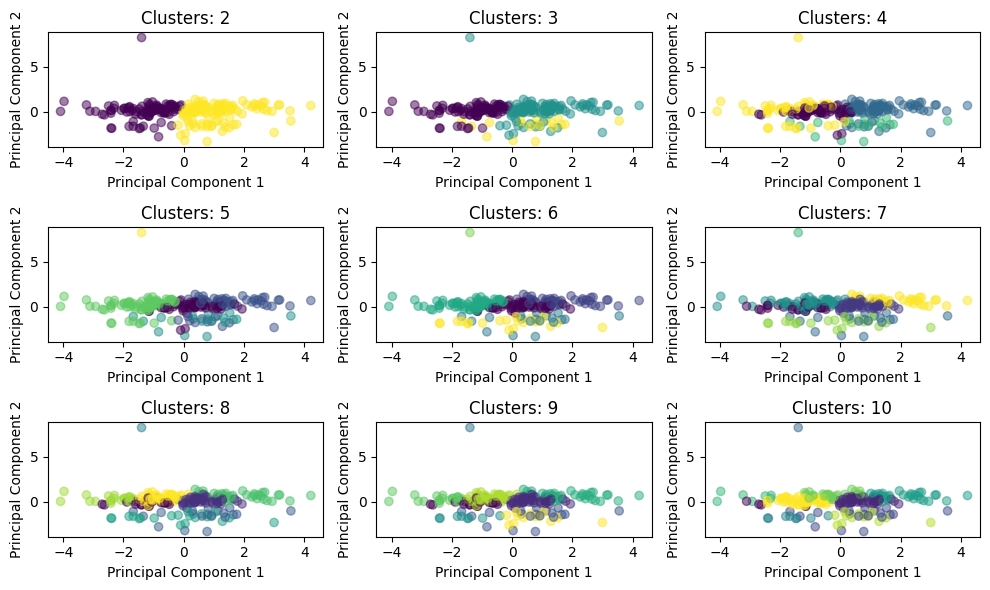

In [42]:
plt.figure(figsize=(10, 6))
for cluster_num in range(2, 11):  # Adjusted range
    kmeans = KMeans(n_clusters=cluster_num, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    plt.subplot(3, 3, cluster_num - 1)
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f'Clusters: {cluster_num}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

## After One Hot Encoding the album
By including the album information as one-hot encoded. This data has a greater impact on the results compared to only sentiment scores. When outputting the cluster information, the clusters are clearly defined by the album they are on. This indicates noise and doesn't help us much.

What's this? the silhouette scores are consistently improving as more clusters are added? These extra columns *must* be improving our results in a meanigful way!

In [43]:
album_encoder = OneHotEncoder()
one_hot_albums = album_encoder.fit_transform(df_cluster[['Album']])
combined_features = np.hstack((scaled_data, one_hot_albums.toarray()))
scaler_combined = StandardScaler()
scaled_combined = scaler_combined.fit_transform(combined_features)
silhouette_scores = []
cluster_numbers = []

sil_scores = compute_silhouette_scores(scaled_combined, 2, 13)
print(sil_scores)

[(2, 0.03849631310245568), (3, 0.07296678633313153), (4, 0.10990444745667534), (5, 0.14148897013570408), (6, 0.18012038248489115), (7, 0.22042487935107657), (8, 0.26522641140161574), (9, 0.2815751267490673), (10, 0.30823161549629413), (11, 0.3519383392922602), (12, 0.3963982727140622), (13, 0.43195906021984337)]


This plot now makes sense as we approach the number of albums in the data, the silhouette score rises. This indicates that the album infomation we One-Hot encoded is more impactful than the sentiment scores. This is known as Dominant Feature Influence and is a common occurance when encoding categorical values

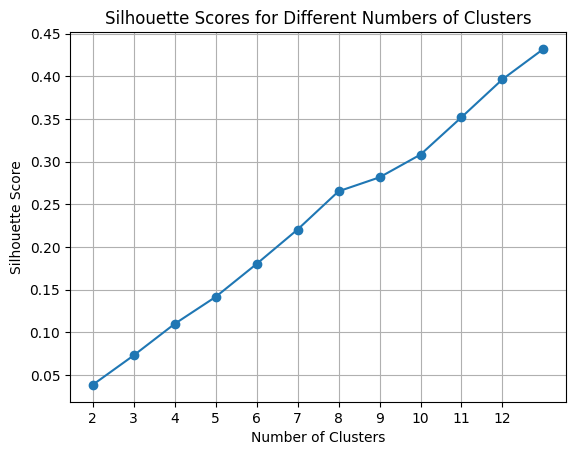

In [44]:
cluster_numbers = [item[0] for item in sil_scores]
silhouette_scores = [item[1] for item in sil_scores]
plt.plot(cluster_numbers, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 13))
plt.grid(True)
plt.show()

Similarly to above, plot out the clusters after adding in the one hot encoded values

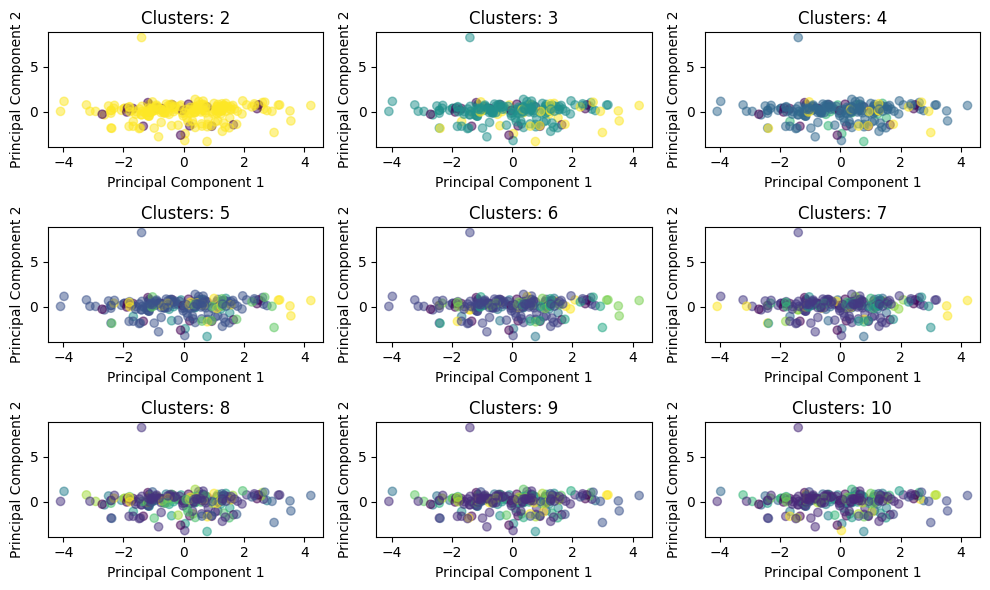

In [45]:
plt.figure(figsize=(10, 6))
for cluster_num in range(2, 11):  
    kmeans = KMeans(n_clusters=cluster_num, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_combined)
    plt.subplot(3, 3, cluster_num - 1)
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f'Clusters: {cluster_num}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

## Preliminary Results
We learned quite a bit from this brief analysis. We learned:
- Debut (Taylor Swift) has the most positive lyrics
- The sentiment relationship between the original song and Taylor's re-record is not the same for all of the re-records
- The Album that a song is on has a greater impact to our classification model than the sentiment scores
- Red and 1989 have the highest song complexity (probably a bad term to choose, but by complexity I mean the average number of sections in the song as well as the number of unique sections per song)
- Red and 1989 also have the most negative average sentiment scores
- There is some indication that the sentiment score may be used as a piece of a greater classification project.
### Suggestions
- If you're looking to use this data, and you have some music knowledge (I do not). Maybe there is a way to add in some musical information (Major key, minor key, instruments, etc.). I expect this would go hand-in-hand with the current data. After all, the lyrics are just a small piece to the puzzle that is a song or an album.
  
I may pick this back up in the future, but for now, this is where I leave the stage.